In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from arc.Binary_Architecture import Model
import os
from data.Data_Interface import DataInterface
from model.Model_Interface import ModelInterface
from cf.DiPACE_FA import DiPACE_FA
from cf.DiPACE_Plus import DiPACE_Plus
from eval.Evaluation import Evaluate
pd.set_option('display.max_columns', None)

/Users/jacobsanderson/Documents/DiPACE/.venv/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
df = pd.read_csv('datasets/credit.csv')
df = df.drop(columns='ZipCode')

In [3]:
encoder = LabelEncoder()
df['Industry'] = encoder.fit_transform(df['Industry'])
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(label_mapping)
df['Ethnicity'] = encoder.fit_transform(df['Ethnicity'])
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(label_mapping)
df['Citizen'] = encoder.fit_transform(df['Citizen'])
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(label_mapping)

{'CommunicationServices': 0, 'ConsumerDiscretionary': 1, 'ConsumerStaples': 2, 'Education': 3, 'Energy': 4, 'Financials': 5, 'Healthcare': 6, 'Industrials': 7, 'InformationTechnology': 8, 'Materials': 9, 'Real Estate': 10, 'Research': 11, 'Transport': 12, 'Utilities': 13}
{'Asian': 0, 'Black': 1, 'Latino': 2, 'Other': 3, 'White': 4}
{'ByBirth': 0, 'ByOtherMeans': 1, 'Temporary': 2}


In [4]:
X = df.drop(columns=['Approved'])
y = df['Approved']

In [5]:
X = pd.get_dummies(X, columns=['Gender', 'Married', 'BankCustomer', 'Industry', 'Ethnicity', 'PriorDefault', 'CreditScore', 'Employed', 'DriversLicense', 'Citizen'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [8]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [9]:
input_size = X_train.shape[1]
model = Model(input_size)

In [10]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

Epoch [10/100], Loss: 0.6648582220077515
Epoch [20/100], Loss: 0.6088383197784424
Epoch [30/100], Loss: 0.529714047908783
Epoch [40/100], Loss: 0.4410918951034546
Epoch [50/100], Loss: 0.35705193877220154
Epoch [60/100], Loss: 0.29042118787765503
Epoch [70/100], Loss: 0.2443591058254242
Epoch [80/100], Loss: 0.2123628407716751
Epoch [90/100], Loss: 0.18753713369369507
Epoch [100/100], Loss: 0.16709989309310913


In [12]:
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predicted = (outputs >= 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test.shape[0]
    print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8260869565217391


In [13]:
model_path = 'pytorch_model.pth'
torch.save(model.state_dict(), model_path)

In [14]:
d = DataInterface(dataframe=df, target='Approved', continuous_features=['Age', 'Debt', 'YearsEmployed', 'Income'])
m = ModelInterface(model_path='../DiPACE/pytorch_model.pth', input_size = input_size)

In [15]:
df = df[df['Approved']==0]
query_index = np.random.choice(len(df))
query_instance = df.iloc[query_index].drop('Approved').to_list()
print(query_index)

270


Desired class: tensor([1.], grad_fn=<RsubBackward1>)
Original class tensor([0.], grad_fn=<RoundBackward0>)
All CFs are classified as the desired class.
Final Loss: tensor(1.2172, grad_fn=<SubBackward0>)
Final Pred Loss: tensor(0.0719, grad_fn=<MeanBackward0>)
Final Proximity Loss: tensor(0.3589, grad_fn=<MeanBackward0>)
Final Diversity Loss: tensor(0.9366, grad_fn=<LinalgDetBackward0>)
Final Sparsity Loss: tensor(0.2918)
Final Plausibility Loss: tensor(2.5510, grad_fn=<AddBackward0>)
Unacceptably high loss. Perturbing relevant features.
All CFs are classified as the desired class.
Final Loss: tensor(1.0781, grad_fn=<SubBackward0>)
Final Pred Loss: tensor(0.0750, grad_fn=<MeanBackward0>)
Final Proximity Loss: tensor(0.3597, grad_fn=<MeanBackward0>)
Final Diversity Loss: tensor(0.9383, grad_fn=<LinalgDetBackward0>)
Final Sparsity Loss: tensor(0.2885)
Final Plausibility Loss: tensor(2.2725, grad_fn=<AddBackward0>)
Unacceptably high loss. Perturbing relevant features.
All CFs are classifie

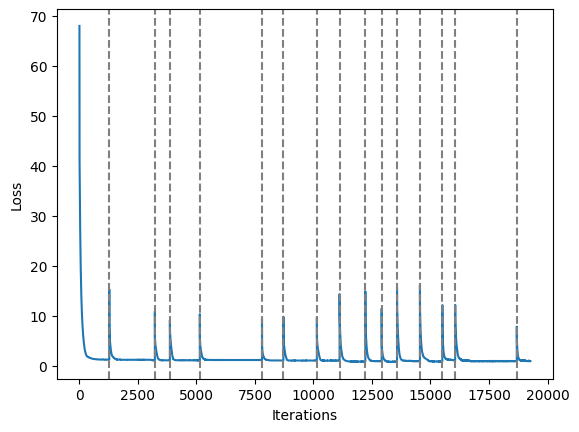

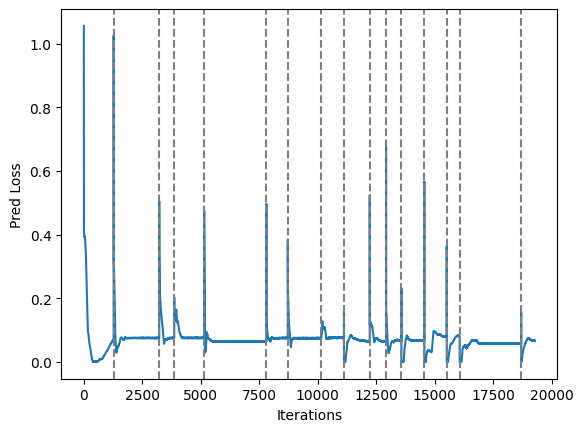

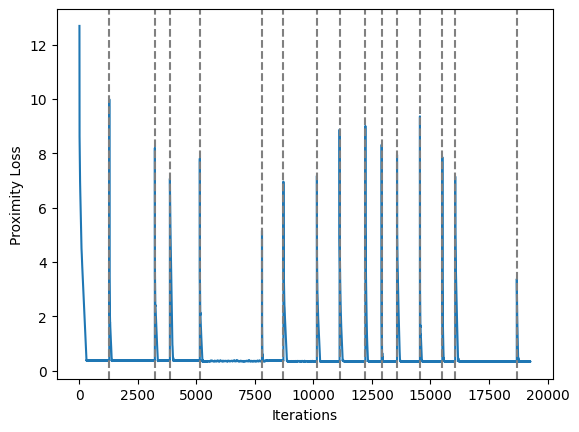

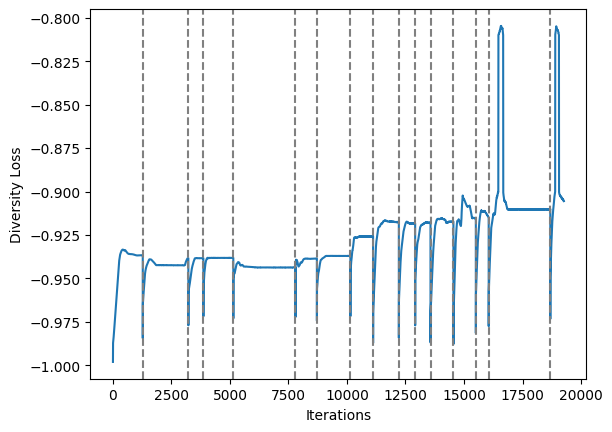

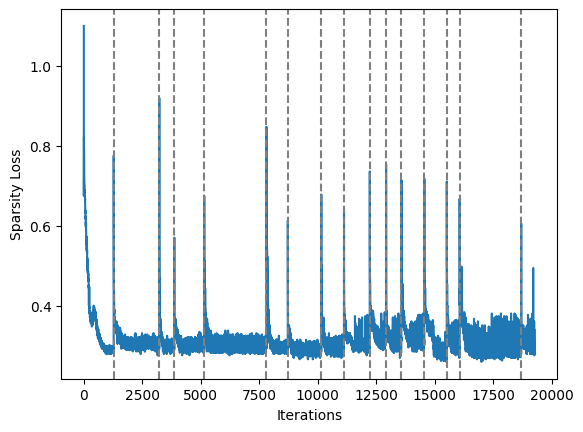

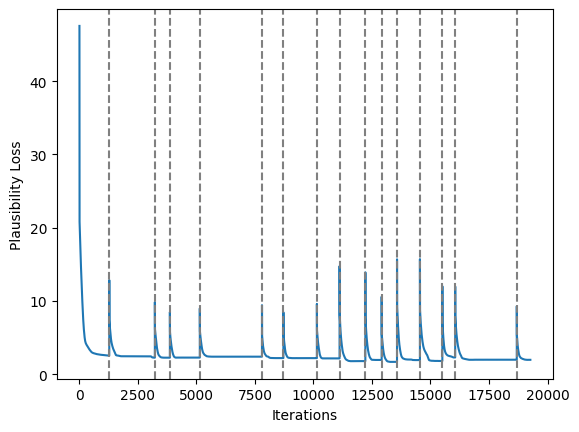

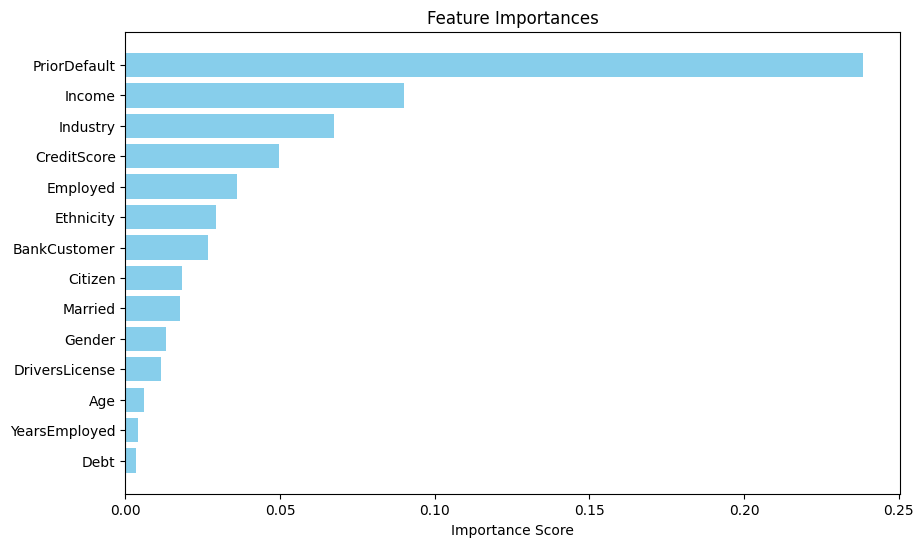

In [16]:
exp = DiPACE_FA(d, m)
cf = exp.generate_counterfactuals(query_instance, total_CFs=5, high_loss_threshold=0.7)

In [17]:
query_instance, cf_instances = cf
query_instance = torch.Tensor(query_instance).float()
cf_instances = torch.Tensor(cf_instances).float()

In [19]:
eval = Evaluate(d, m)
eval.evaluate(query_instance, cf_instances, d.norm_encoded_features, desired_class=1, k=1)

Proximity: tensor(0.2417)
Sparsity: tensor(0.2590)
Diversity: tensor(0.9115)
Plausibility: tensor(1.1905)
Confidence: tensor(0.8817, grad_fn=<RsubBackward1>)
